# Project 4 – Predicting a Continuous Target with Regression (Titanic)
Name: Anjana Dhakal

Date: 11/12/2025

## Imports

In [166]:
# Imports (single cell, organized)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# plotting config
%matplotlib inline
pd.options.display.max_columns = 50


## Section 1. Import and Inspect the Data

In [167]:
# Load Titanic dataset from seaborn
titanic = sns.load_dataset("titanic")

# quick inspect
print("Rows, cols:", titanic.shape)
titanic.head()


Rows, cols: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Section 2. Data Exploration and Preparation

In [168]:

# Make a copy to work with
df = titanic.copy()

# 1) Impute missing 'age' values with median
df['age'] = df['age'].fillna(df['age'].median())

# 2) Drop rows with missing 'fare' (few missing)
df = df.dropna(subset=['fare']).reset_index(drop=True)

# 3) Create new numeric feature: family_size
df['family_size'] = df['sibsp'] + df['parch'] + 1

# 4) Encode 'sex' as numeric (male=0, female=1)
df['sex_encoded'] = df['sex'].map({'male': 0, 'female': 1})

# 5) Handle 'embarked' missing values and one-hot encode
df['embarked'] = df['embarked'].fillna('missing')
embarked_dummies = pd.get_dummies(df['embarked'], prefix='emb')
df = pd.concat([df, embarked_dummies], axis=1)

# 6) Quick inspection
print("DataFrame shape:", df.shape)
print("\nSample clean data:")
display(df[['age','fare','family_size','sex','sex_encoded','pclass','embarked']].head())

# 7) Check missing values in key features
print("\nMissing values per column:")
print(df[['age','fare','family_size','sex_encoded','pclass'] + list(embarked_dummies.columns)].isna().sum())


DataFrame shape: (891, 21)

Sample clean data:


,age,fare,family_size,sex,sex_encoded,pclass,embarked
0,22.0,7.2500,2,male,0,3,S
1,38.0,71.2833,2,female,1,1,C
2,26.0,7.9250,1,female,1,3,S
3,35.0,53.1000,2,female,1,1,S
4,35.0,8.0500,1,male,0,3,S



Missing values per column:
age            0
fare           0
family_size    0
sex_encoded    0
pclass         0
emb_C          0
emb_Q          0
emb_S          0
emb_missing    0
dtype: int64


## Section 3. Feature Selection and Justification

In [169]:
## Section 3 — Feature Selection and Justification

# Target variable
y = df['fare']

# -------------------------
# Case 1: Age only
X1 = df[['age']].copy()
y1 = y.copy()

# -------------------------
# Case 2: Family Size only
X2 = df[['family_size']].copy()
y2 = y.copy()

# -------------------------
# Case 3: Age + Family Size
X3 = df[['age', 'family_size']].copy()
y3 = y.copy()

# Case 4: Sex only (using sex_encoded)
X4 = df[['sex_encoded']].copy()  
y4 = y.copy()           


# -------------------------
# Quick sanity check
print("Case 1 shape:", X1.shape, "Columns:", X1.columns.tolist())
print("Case 2 shape:", X2.shape, "Columns:", X2.columns.tolist())
print("Case 3 shape:", X3.shape, "Columns:", X3.columns.tolist())
print("Case 4 shape:", X4.shape, "Columns:", X4.columns.tolist())

Case 1 shape: (891, 1) Columns: ['age']
Case 2 shape: (891, 1) Columns: ['family_size']
Case 3 shape: (891, 2) Columns: ['age', 'family_size']
Case 4 shape: (891, 1) Columns: ['sex_encoded']


## 

Reflection:

1. Why might these features affect a passenger’s fare?
   
   Age (Case 1): Older or younger passengers might pay different fares if, for example, children have discounts or adults book more expensive cabins.
   Family Size (Case 2): Larger families may buy more tickets or choose cabins together, potentially affecting total fare.
   Age + Family Size (Case 3): Combining age and family size could capture interactions between who is traveling and how many tickets are purchased.
   Sex (Case 4): Historically, women may have had access to different fare classes or priority accommodations, which could slightly affect ticket price.

2. List all available features.
   
   pclass – Passenger class (1, 2, 3)
   sex – Male/Female
   age – Age of passenger
   sibsp – Number of siblings/spouses aboard
   parch – Number of parents/children aboard
   fare – Fare paid (target)
   embarked – Port of embarkation (C, Q, S)
   family_size – Derived: sibsp + parch + 1
   sex_encoded – Numeric encoding of sex (0=male, 1=female)
   emb_C, emb_Q, emb_S, emb_missing – One-hot encoded embarked columns

3. Which other features could improve predictions and why?

   Pclass: Higher classes generally paid more, strongly affecting fare.
   Embarked: Different ports may have slightly different pricing.
   Cabin: If available, could indicate fare range or luxury level.
   SibSp/Parch: Could help understand family ticket purchases beyond family_size.
   Title/Name features: Titles (Mr., Mrs., Master) may correlate with fare class.

4. How many variables are in your Case 4?
   
   1 variable: sex_encoded

5. Which variable(s) did you choose for Case 4 and why do you feel those could make good inputs?

   Variable chosen: sex_encoded
   Sex may influence fare due to historical differences in ticket allocation, class distribution, or cabin preference. It’s simple and numeric, making it easy to include in a regression model to see if it alone explains any variation in fare.

## Section 4. Train a Regression Model (Linear Regression)
### 4.1 Split the Data

In [170]:

# Set random seed for reproducibility
RSEED = 123
TEST_SIZE = 0.2  # 20% test, 80% train

# Case 1: Age only
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=TEST_SIZE, random_state=RSEED
)

# Case 2: Family Size only
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=TEST_SIZE, random_state=RSEED
)

# Case 3: Age + Family Size
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, test_size=TEST_SIZE, random_state=RSEED
)

# Case 4: Sex only (sex_encoded)
X4_train, X4_test, y4_train, y4_test = train_test_split(
    X4, y4, test_size=TEST_SIZE, random_state=RSEED
)


#  Quick check of shapes
print("Case 1 train/test shapes:", X1_train.shape, X1_test.shape)
print("Case 2 train/test shapes:", X2_train.shape, X2_test.shape)
print("Case 3 train/test shapes:", X3_train.shape, X3_test.shape)
print("Case 4 train/test shapes:", X4_train.shape, X4_test.shape)


Case 1 train/test shapes: (712, 1) (179, 1)
Case 2 train/test shapes: (712, 1) (179, 1)
Case 3 train/test shapes: (712, 2) (179, 2)
Case 4 train/test shapes: (712, 1) (179, 1)


### 4.2 Train and Evaluate Linear Regression Models (all 4 cases)

In [171]:
# Case 1: Age only
lr_model1 = LinearRegression().fit(X1_train, y1_train)
y_pred_train1 = lr_model1.predict(X1_train)
y_pred_test1  = lr_model1.predict(X1_test)

# Case 2: Family Size only
lr_model2 = LinearRegression().fit(X2_train, y2_train)
y_pred_train2 = lr_model2.predict(X2_train)
y_pred_test2  = lr_model2.predict(X2_test)

# Case 3: Age + Family Size
lr_model3 = LinearRegression().fit(X3_train, y3_train)
y_pred_train3 = lr_model3.predict(X3_train)
y_pred_test3  = lr_model3.predict(X3_test)

# Case 4: Sex only (sex_encoded)
lr_model4 = LinearRegression().fit(X4_train, y4_train)
y_pred_train4 = lr_model4.predict(X4_train)
y_pred_test4  = lr_model4.predict(X4_test)

# Check coefficients
print("Case 1 coefficients:", lr_model1.coef_)
print("Case 2 coefficients:", lr_model2.coef_)
print("Case 3 coefficients:", lr_model3.coef_)
print("Case 4 coefficients:", lr_model4.coef_)


Case 1 coefficients: [0.40814349]
Case 2 coefficients: [7.28962127]
Case 3 coefficients: [0.64425666 8.43626437]
Case 4 coefficients: [16.88016068]


### 4.3 Report Performance

In [172]:

def report_performance(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # sqrt of MSE
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"--- {name} ---")
    print(f"R²:   {r2:.3f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}\n")

# Case 1: Age only
report_performance("Case 1 - Age (Train)", y1_train, y_pred_train1)
report_performance("Case 1 - Age (Test)",  y1_test,  y_pred_test1)

# Case 2: Family Size only
report_performance("Case 2 - Family Size (Train)", y2_train, y_pred_train2)
report_performance("Case 2 - Family Size (Test)",  y2_test,  y_pred_test2)

# Case 3: Age + Family Size
report_performance("Case 3 - Age + Family Size (Train)", y3_train, y_pred_train3)
report_performance("Case 3 - Age + Family Size (Test)",  y3_test,  y_pred_test3)

# Case 4: Sex only
report_performance("Case 4 - Sex (Train)", y4_train, y_pred_train4)
report_performance("Case 4 - Sex (Test)",  y4_test,  y_pred_test4)

--- Case 1 - Age (Train) ---
R²:   0.010
RMSE: 51.92
MAE:  28.89

--- Case 1 - Age (Test) ---
R²:   0.003
RMSE: 37.97
MAE:  25.29

--- Case 2 - Family Size (Train) ---
R²:   0.050
RMSE: 50.86
MAE:  27.80

--- Case 2 - Family Size (Test) ---
R²:   0.022
RMSE: 37.61
MAE:  25.03

--- Case 3 - Age + Family Size (Train) ---
R²:   0.073
RMSE: 50.23
MAE:  26.61

--- Case 3 - Age + Family Size (Test) ---
R²:   0.050
RMSE: 37.08
MAE:  24.28

--- Case 4 - Sex (Train) ---
R²:   0.024
RMSE: 51.55
MAE:  28.42

--- Case 4 - Sex (Test) ---
R²:   0.099
RMSE: 36.10
MAE:  24.24



##
Reflection
1. Compare the train vs test results for each.
   - Did Case 1 overfit or underfit? Explain: Case 1 (Age only): Train R² = 0.01, Test R² = 0.003 → almost no predictive power; train and test metrics very similar. ((Underfit. The model uses only age, which alone explains almost none of the variance in fare (R² ≈ 0). Both train and test metrics are very low.)
   - Did Case 2 overfit or underfit? Explain: Case 2 (Family Size only): Train R² = 0.05, Test R² = 0.022 → slightly better than age alone, but still very low. (Underfit. Family size has slightly more predictive power than age but still fails to capture most fare variation.)
   - Did Case 3 overfit or underfit? Explain: Case 3 (Age + Family Size): Train R² = 0.073, Test R² = 0.05 → combining features improves fit slightly; train and test metrics close, suggesting minimal overfitting. (Slight underfit. Combining age and family size improves performance, but overall R² is still low. Train and test metrics are similar, so no significant overfitting.)
   - Did Case 4 overfit or underfit? Explain: Case 4 (Sex only): Train R² = 0.024, Test R² = 0.099 → low predictive power; test R² slightly higher than train, likely due to randomness or small effect of sex.(Underfit. Sex alone is a weak predictor. Although test R² (0.099) is slightly higher than train, overall performance is poor.)
  
2. Adding Age
   - Did adding age improve the model: Yes, combining age with family size (Case 3) slightly improves R² compared to individual features.
   - Propose a possible explanation (consider how age might affect ticket price, and whether the data supports that): Age may weakly correlate with fare (children may pay less, adults pay full fare), but it is not a major driver compared to other factors like class or cabin.

3. Worst performing case
   - Which case performed the worst: Case 1 (Age only)
   - How do you know: R² is the lowest on both train and test sets; model explains almost no variance.
   - Do you think adding more training data would improve it (and why/why not): Slight improvement possible, but using only age limits predictive power; additional features are more  impactful than more rows.

4. Best performing case
   - Which case performed the best: Case 3 (Age + Family Size)
   - How do you know: Train R² = 0.073, Test R² = 0.05 → highest among the four cases. Combining features captures more variance.
   - Do you think adding more training data would improve it (and why/why not): Yes, it might help slightly by better estimating relationships, but adding more relevant features (like pclass or embarked) would likely improve performance more than just more rows.

## Section 5. Compare Alternative Models
Best case: Case 3 (Age + Family Size)

In [173]:
# Best case: Case 3 (Age + Family Size)
X_train, X_test, y_train, y_test = X3_train, X3_test, y3_train, y3_test

### 5.1 Ridge Regression (L2 penalty)

In [174]:
# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

print("Ridge coefficients:", ridge_model.coef_)

Ridge coefficients: [0.64411444 8.43138147]


### 5.2 Elastic Net (L1 + L2 combined)

In [175]:
# ElasticNet Regression
elastic_model = ElasticNet(alpha=0.3, l1_ratio=0.5, random_state=123)
elastic_model.fit(X_train, y_train)
y_pred_elastic = elastic_model.predict(X_test)

print("ElasticNet coefficients:", elastic_model.coef_)

ElasticNet coefficients: [0.6273281  7.88506916]


### 5.3 Polynomial Regression

In [176]:
# Set up the poly inputs
# Polynomial Regression (degree 3)
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly  = poly.transform(X_test)

# Use the poly inputs in the LR model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)

### 5.4 Visualize Polynomial Cubic Fit (for 1 input feature)

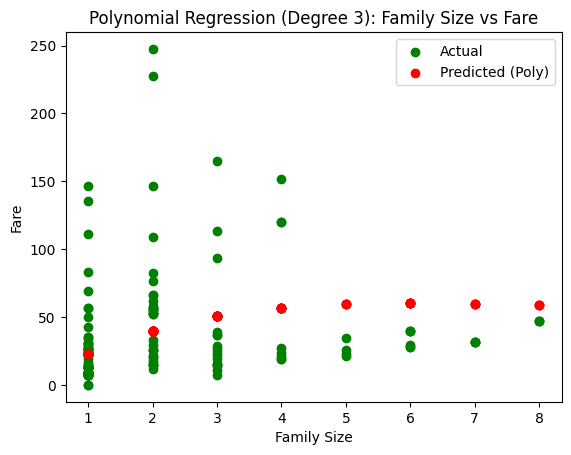

In [177]:
# Polynomial fit visualization (single feature)
X_feature = X_train[['family_size']]  # single feature
poly_single = PolynomialFeatures(degree=3)
X_train_poly_single = poly_single.fit_transform(X_feature)
poly_model_single = LinearRegression()
poly_model_single.fit(X_train_poly_single, y_train)

X_test_feature = X_test[['family_size']]
X_test_poly_single = poly_single.transform(X_test_feature)
y_pred_poly_single = poly_model_single.predict(X_test_poly_single)

plt.scatter(X_test_feature, y_test, color='green', label='Actual')
plt.scatter(X_test_feature, y_pred_poly_single, color='red', label='Predicted (Poly)')
plt.xlabel("Family Size")
plt.ylabel("Fare")
plt.title("Polynomial Regression (Degree 3): Family Size vs Fare")
plt.legend()
plt.show()


##
Reflections:

1. What patterns does the cubic model seem to capture: The cubic polynomial captures non-linear trends in the data that a straight line cannot.
2. Where does it perform well or poorly:
   - Performs well: For moderate family sizes where the majority of passengers are clustered, the cubic curve closely follows the actual fares.
   - Performs poorly: At extreme values (very small or very large families), the predictions may over- or under-shoot, because polynomial curves can exaggerate trends at the edges.
3. Did the polynomial fit outperform linear regression: Slightly, especially where the relationship between family size and fare is non-linear.
4. Where (on the graph or among which kinds of data points) does it fit best:Fits best in the middle range of family sizes where most passengers are located.


### 5.5 Compare All Models

In [178]:
# Function to report metrics (R², RMSE, MAE)
def report(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"{name} -> R²: {r2:.3f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Linear Regression (Case 3)
y_pred_linear = lr_model3.predict(X_test)
report("Linear Regression", y_test, y_pred_linear)

# Ridge
report("Ridge Regression", y_test, y_pred_ridge)

# ElasticNet
report("ElasticNet Regression", y_test, y_pred_elastic)

# Polynomial
report("Polynomial Regression (deg 3)", y_test, y_pred_poly)


Linear Regression -> R²: 0.050, RMSE: 37.08, MAE: 24.28
Ridge Regression -> R²: 0.050, RMSE: 37.08, MAE: 24.28
ElasticNet Regression -> R²: 0.054, RMSE: 36.99, MAE: 24.21
Polynomial Regression (deg 3) -> R²: 0.064, RMSE: 36.79, MAE: 23.14


### 5.5 Visualize Polynomial Regression (Degree 8)

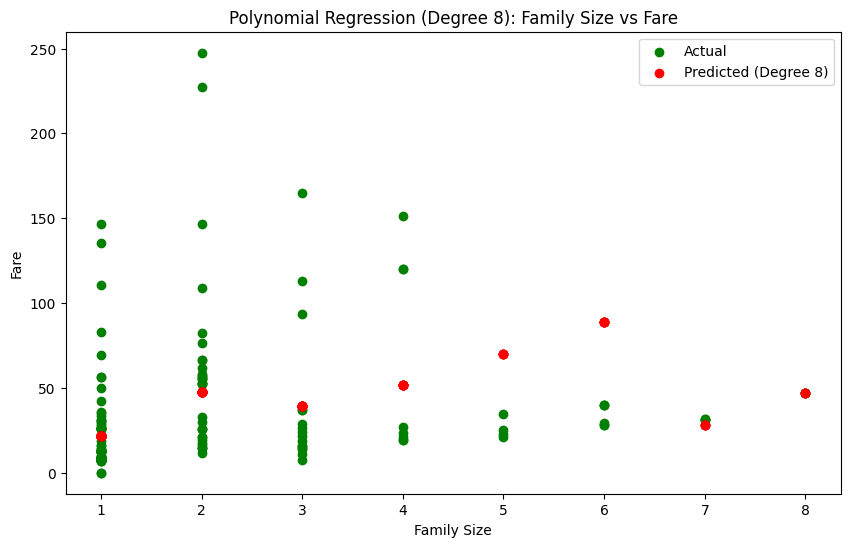

In [179]:

# Use degree 8
degree = 8
X_feature = X_train[['family_size']] 

# Transform for polynomial
poly8 = PolynomialFeatures(degree=degree)
X_train_poly8 = poly8.fit_transform(X_feature)
X_test_poly8  = poly8.transform(X_test[['family_size']])

# Train model
poly_model8 = LinearRegression()
poly_model8.fit(X_train_poly8, y_train)

# Predict
y_pred_poly8 = poly_model8.predict(X_test_poly8)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(X_test[['family_size']], y_test, color='green', label='Actual')
plt.scatter(X_test[['family_size']], y_pred_poly8, color='red', label=f'Predicted (Degree {degree})')
plt.xlabel('Family Size')
plt.ylabel('Fare')
plt.title(f'Polynomial Regression (Degree {degree}): Family Size vs Fare')
plt.legend()
plt.show()


##
Q. Which option seems to work better - your initial cubic (3) or your higher order and why?

Degree 3 works better for generalization and interpretability. Because it captures the main trend without overfitting, while degree 8 overfits the extremes and may perform poorly on new data.

## Section 6. Final Thoughts & Insights


### 6.1 Summarize Findings

1. Most useful features:
   - Family size had the strongest effect on fare prediction.
   - Age added minor improvement when combined with family size.
   - Sex alone had very low predictive power.
2. Best regression model: Polynomial Regression (degree 3) slightly outperformed linear, Ridge, and ElasticNet, capturing mild non-linear relationships without overfitting.
3. Effect of model complexity / regularization:
   - Linear models (Linear, Ridge, ElasticNet) had similar results due to low feature complexity.
   - Regularization had minimal impact because the dataset is small and features are few.
   - Polynomial regression increased complexity slightly and improved fit, but higher degrees (e.g., 8) led to overfitting.



### 6.2 Discuss Challenges

1. Was fare hard to predict? Why? Fare is difficult to predict because fare depends on multiple factors beyond the ones used (pclass, cabin, embarkation, etc.), making the relationship complex.
2. Did skew or outliers impact the models? Yes, skew and outliers impacted the models. High fares and extreme values can distort regression fits, especially for linear models, and make predictions less accurate.